# Tutorial 4: Kelly Formula and Risk Measures

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sys
import os
from scipy.stats import norm, t, ecdf

In [3]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

In [4]:
import matplotlib as mpl
CMAP = sns.diverging_palette(20, 220, as_cmap=True)

def normalize_color(center=None, vmin=None, vmax=None):
    if center is not None:
         return mpl.colors.CenteredNorm(vcenter=center)    
    else:
        return mpl.colors.Normalize(vmin=vmin, vmax=vmax)


def plot_surface(df, figsize=(15, 10), title='',
                 xlabel=None, ylabel=None, contour=True,
                 center=None, vmin=None, vmax=None,
                 aspect=(1, 1, 1), contour_margins=(0.25, 0.5, 1),
                 elev=30, azim=-135):
    """
    :param df: should be grid-like, index will be 'x', columns will be 'y'
    :param figsize:
    :param title:
    :param xlabel:
    :param ylabel:
    :param aspect:
    :param contour_margins:
    :return:
    """

    xlabel = xlabel or df.index.name or "x"
    ylabel = ylabel or df.columns.name or "y"

    x, y = df.index, df.columns
    if isinstance(x, pd.DatetimeIndex):
        x = ut.dt2num(x)
    if isinstance(y, pd.DatetimeIndex):
        y = ut.dt2num(y)
    X, Y = np.meshgrid(x, y)
    Z = df.T.values

    ax = plt.figure(figsize=figsize).add_subplot(projection='3d')
    color_norm = normalize_color(center=center, vmin=vmin, vmax=vmax)
    ax.plot_surface(X, Y, Z, cmap=CMAP, norm=color_norm)
    ax.set_box_aspect(aspect=aspect)

    kwargs = {}
    if contour:
        for dim, var, offset_dir, margin in zip(['x', 'y', 'z'], [x, y, Z], ['-', '+', '-'], contour_margins):
            var_min, var_max = np.nanmin(var), np.nanmax(var)
            var_range = var_max - var_min

            if offset_dir == '-':
                offset = var_min - margin * var_range
                kwargs[f'{dim}lim'] = (offset, var_max)
            else:
                offset = var_max + margin * var_range
                kwargs[f'{dim}lim']  = (var_min, offset)

            kwargs[f'{dim}ticks'] = ax.__getattribute__(f'get_{dim}ticks')()
            ax.contourf(X, Y, Z, zdir=dim, offset=offset, cmap=CMAP)

    ax.set(title=title, xlabel=xlabel, ylabel=ylabel, **kwargs)
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    return ax

In [5]:
random_state = np.random.default_rng(12345)

## 1. Kelly's Formula

### 1.1 Motivation

Suppose that a profit-maximizing investor is deciding when to sell a stock over a fixed time period.

A reasonable refomulation is: When should he sell the stock in order to minimize the expected relative error between the selling price and the “true” maximum price?

### 1.2 Goodness Index $\alpha$

Shiryaev showed that under a Black-Scholes market, 

Define the goodness index $\alpha := \mu/\sigma^2$, where $\mu$ and $\sigma$ are respectively the expected rate of the return and the volatility

One should buy a stock and hold it until the end of the investment period $T$ when $\alpha \geq 1/2$; otherwise, one should sell it at once when $\alpha < 1/2$.

\begin{align*}
dS_t &= \mu S_t dt + \sigma S_t dW_t \\
\implies \mathbb{E}[\ln{\frac{S_t}{S_0}}] &= (\mu - \frac{\sigma^2}{2}) t 
\end{align*}

Clearly, $\alpha > \frac{1}{2}$ is equivalent to a positive expected log returns of $S_t$

### 1.3 Long-term Wealth Maximization

Next, consider a portfolio $\Pi_t = w_t S_t + (1-w_t) B_t$, where $S_0 = B_0 = 1$,

$w_t \in [0,1]$ is the weight on one risky asset $S_t$,


and $B_t$ is a risk-free asset such that $dB_t = rB_tdt$:

One can similarly show:

\begin{align*}
\text{Define } f_t &:= \frac{w_t S_t}{\Pi_t} \\
\mathbb{E}[ d \ln (\Pi_t) ] &= (r + (\mu - r)f_t - \frac{\sigma^2}{2} f_t^2) dt \\
\implies f_t^* &= \frac{\mu - r}{\sigma^2}
\end{align*}

$f_t^*$ is known as the Kelly's fraction, which is the % of dollar allocated in $S_t$.

There are many other methods to compute an 'optimal' portfolio weight, e.g. Mean-Variance Optimization. 

It depends on how you define your objective functions and constraints.

### 1.4 (Optional) Discrete Time, Binary Outcomes

Usually, when people talk about Kelly fraction $f^*$, they refer to a casino like setting, 

where you play the same game a number of times, and the outcome is either winning or losing a certain amount of money.

Then, let $p$ be the winning probability, $n$ the the number of games played, so $X \sim Bin(n, p)$

Also, let $a, b$ be the $\%$ win/lose, and $f$ be your bet size.

Then: 
\begin{align*}
\mathbb{E} [\ln(W_n / W_0)] &= np \ln (1 + fa) + n(1 - p) \ln(1 - fb) \\
\implies \frac{pa}{1 + f^*a} &= \frac{(1-p)b}{1-f^*b} \\
\implies f^* &= \frac{p}{b} - \frac{1-p}{a}
\end{align*}

(In the casion setting, you lose all your bet if the outcome is against you, so $b$ is simply $100\%$.)

In [18]:
p = np.linspace(0.01, 1, 101)
a = np.linspace(0.001, 2, 2001)

kelly_fraction = p[:, None] - (1-p)[:, None] / a[None, :]
kelly_fraction = pd.DataFrame(kelly_fraction, index=p, columns=a)
kelly_fraction = kelly_fraction.clip(lower=0)
kelly_fraction = kelly_fraction.rename_axis(index='win_prob (p)').rename_axis(columns='odds (a)')

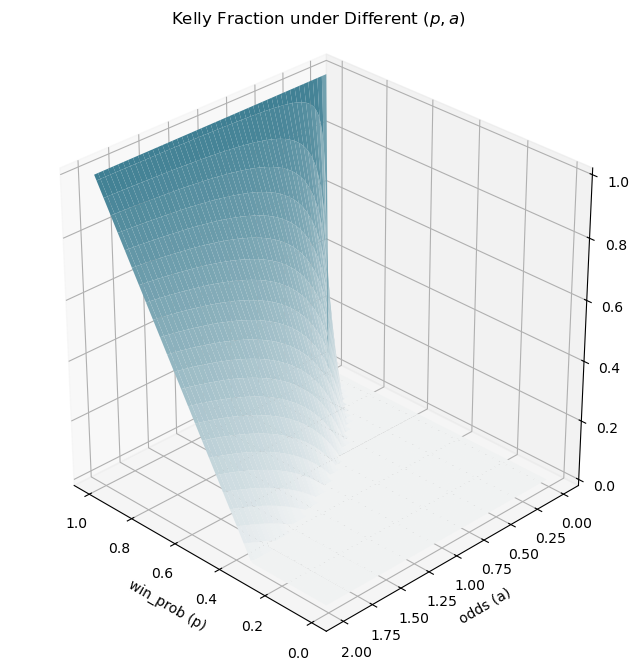

In [19]:
plot_surface(kelly_fraction, title=f'Kelly Fraction under Different $(p, a)$',
             azim=135, elev=30, contour=False, figsize=(8, 8), center=0);

## 2. Value at Risk (V@R)

Recall that V@R of a portfolio is a measure of how much we might lose over a given time period, under normal market conditions, and with a specified probability $p$. 

In other words, the $p$-V@R can be defined informally as the maximum possible loss during that given time period after we exclude all the worst outcomes whose combined probability is at most $p$.

<u>Example</u>: 

If a portfolio of stocks has a one-day $5\%$ V@R of $\$1$ million, 

that means that there is a $5\%$ probability that the portfolio will fall in value by more than $\$1$ million over a one-day period if there is no trading

There are multiple methods of estimating/calculating the V@R:
1. Non-parametric approach: historical simulations, which utilize the empirical distribution of past returns
2. Parametric approach: normality or the t-distributed return assumption.

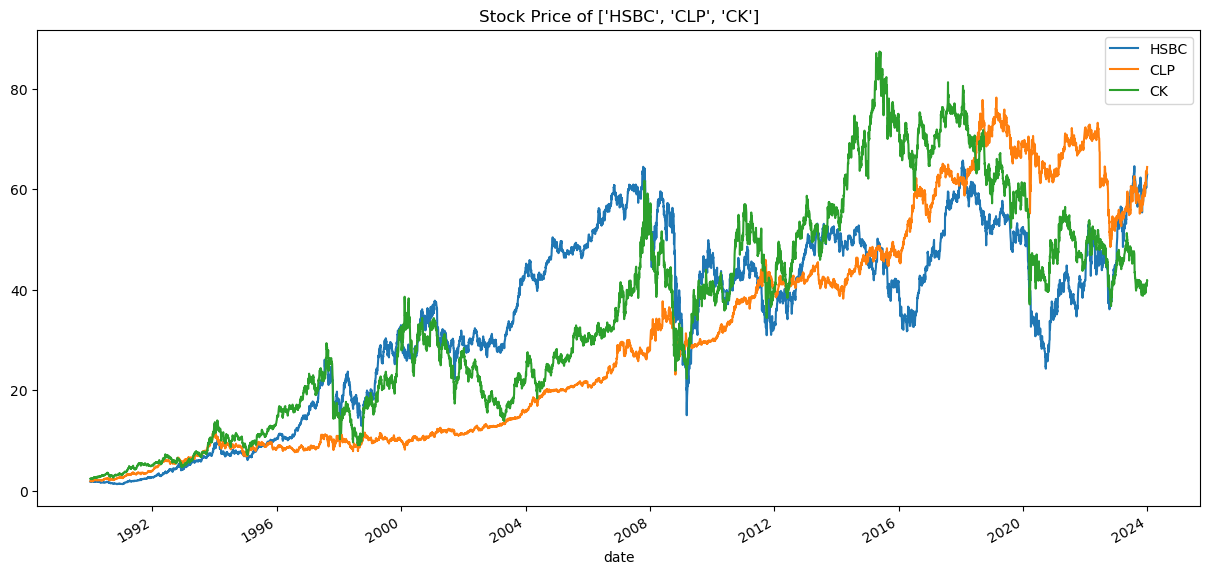

In [24]:
px = read_file('HSI/HSI_1990_2024.csv', index_col=0) # means we set column 0 as the index
px = px.rename_axis('date')
px.index = pd.to_datetime(px.index)
px = px.ffill(limit=None)
px.plot(figsize=(15, 7), title=f"Stock Price of {list(px.columns)}");

rets = np.log(px).diff().iloc[1:]

### 2.1 Non-Parametric Approach: Historical Simulation

In historical simulation of V@R, we are constructing an empirical distribution of daily returns using our past (observed) daily returns. 

Suppose that today is day $n$ and $\nu_i$ is the value of a market variable (stock price or index). 

Then the value tomorrow $n+1$ estimated based on the $i$-th scenario is:

\begin{equation*}
	\hat{\nu}(i) = \nu_n \times \frac{\nu_i}{\nu_{i-1}} \, , \qquad i=1, \cdots, n \, .
\end{equation*}

The $x\%$-V@R is calculated by the $x\%$ quantile of this simulated distribution of returns.

<u>Example</u>: 

Suppose that we spend $\$40,000$ on buying HSBC, $\$30,000$ on CLP, and $\$30,000$ on CK. 

Mathematically speaking, we let the amounts of investment in each stock be

\begin{equation*}
    \mathbf \omega = \left(\begin{array}{c}
        \omega_1 \\ \omega_2 \\ \omega_3
    \end{array}\right) = \left(\begin{array}{c}
        40,000	\\	30,000	\\	30,000
    \end{array}\right) \, .
\end{equation*}

We then compute the 1-day 95\%-V@R and 99\%-V@R of this portfolio using historical simulation. 

In the below demo, ```rets_sim``` matrix gives the simulated stock returns on each simulated day.

which then can be used to calculate profit/loss for V@R, since PnL is a weighted sum of returns and dollar allocation.

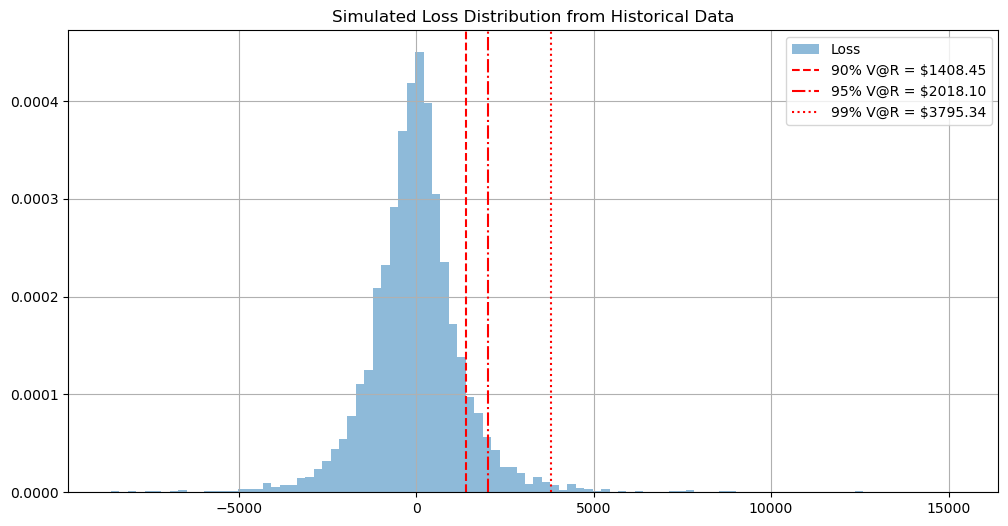

In [28]:
from itertools import cycle
linestyles = cycle(['--', '-.', ':', '.'])

# Generate Initial Positions
dollar_pos = pd.Series([40000, 30000, 30000], index=px.columns)

# Simulate 1-day future returns
n_sim = 10000
rets_sim = rets.sample(n_sim, replace=True, random_state=random_state)

# dollor loss = (-1) * sum(dollar_i * ret_i)
loss = (-1) * (rets_sim @ dollar_pos)

# Plot Loss Stats
alphas = [0.9, 0.95, 0.99]
var_sim = loss.quantile(alphas) # VaR is the largest alpha % Loss 

ax = loss.hist(bins=n_sim//100, alpha=0.5,
            density=True, label='Loss', figsize=(12, 6));

for a, v in var_sim.items():
    label = rf'{(a * 100):.0f}% V@R = ${v:.2f}'
    plt.axvline(v, label=label, color='r', linestyle=next(linestyles))
    
ax.title.set_text('Simulated Loss Distribution from Historical Data');
plt.legend();
plt.show();

### 2.2 Parametric Approach: Normal Model

Under the normal approach, we assume that the returns follow a normal distribution (or multivariate normal when considering multiple assets). 

We can then obtain the $x\%$-V@R by fitting a normal distribution and calculating quantiles of the fitted distribution.

\
Let $u_1$, $u_2$, and $u_3$ be the daily returns of the stocks of HSBC, CLP, and CK respectively. 

If the time period is short, we may assume that $\mathbf u = (u_1, u_2, u_3 )^\top$ follows a tri-variate normal distribution with mean zero and covariance matrix $\mathbf \Sigma$. 

\
Mathematically speaking, let

\begin{equation*}
	\mathbf u = \left(\begin{array}{c}
		u_1	\\	u_2	\\	u_3
	\end{array}\right) \sim \mathcal{N}_3 (\mathbf 0, \mathbf \Sigma).
\end{equation*}
The change in the portfolio value is given by:
\begin{equation*}
	\Delta P = \mathbf \omega^\top \mathbf u = \omega_1 u_1 + \omega_2 u_2 + \omega_3 u_3 \, ,
\end{equation*}
with mean and estimated variance, respectively:
\begin{equation*}
	\mathbb{E}(\Delta P) = \mathbf \omega \mathbb{E}(\mathbf u^\top) = \mathbf 0 \qquad \text{and} \qquad {\rm Var}(\Delta P) =  {\rm Var}(\mathbf \omega^\top \mathbf u )  = \mathbf \omega^\top \mathbf S \mathbf \omega \, ,
\end{equation*}
where the sample covariance matrix $\mathbf S$ is used to replace the unknown $\mathbf \Sigma$.

The 1-day 99\%-V@R is given by $z_{0.99} \times \sqrt{\mathbf \omega^\top \mathbf S \mathbf \omega}$, where $z_{0.99} \approx 2.326$ is the 99-th percentile of the standard normal distribution.

In [33]:
dollor_ret_std = (rets @ dollar_pos).std() 
var_normal = pd.Series(dollor_ret_std * norm.ppf(alphas), index=alphas)

### 2.3 Parametric Approach: t-distribution Model

Alternatively, we can model the changes in the portfolio value using Student’s t-distribution.

Recall that the excess kurtosis of a t-distribution with $\nu$ degrees of freedom is given by: $K=6/(\nu-4)$. 

Rearranging this yields $\nu=6/K+4$. 

Thus, calculating the sample excess kurtosis and plugging it into the above to obtain an estimate of the degrees of freedom $\nu$.

Since $SD(t_v)=\sqrt{\frac{v}{v-2}}$, we know $\frac{w^Tu}{SD(w^Tu)} (\sqrt{\frac{v}{v-2}}) \sim t_v$, so:

The 1-day $(1- \alpha) \% \text{ V@R } \approx - SD(w^Tu) * (\sqrt{\frac{v-2}{v}}) * t_{v, \alpha}$

In [36]:
excess_kurt = (rets @ dollar_pos).kurt() - 3
v = round(6 / excess_kurt + 4)
var_t = pd.Series(dollor_ret_std * t.ppf(alphas, df=v) * np.sqrt((v-2) / v), index=alphas)

### 2.4 VaR Comparison

In [38]:
var_df = pd.concat({'simulation': var_sim,
                   'normal': var_normal,
                   f"student's t (df={v})": var_t}, axis=1)
var_df.round(2)

,simulation,normal,student's t (df=5)
0.90,1408.45,1763.45,1573.09
0.95,2018.10,2263.36,2147.77
0.99,3795.34,3201.11,3586.56


<u>Summary</u>

Using the normal model, the 1-day 99\%-V@R is less than the simulated V@R.

But the 90\% and 95\%-V@R are greater than the simulated V@R.

The normality assumption tends to underestimate the risk exposure.

\
Now, using t-distribution model, the V@R is closer to the simulated V@R.

However, the t-distribution still assumes the returns are symmetric, which is generally not the case for risky assets.

### 2.5 Backtesting

Let the 1-day $x \times 100$\%-V@R be $\$V$. 

An exception occurs if the loss is greater than $\$V$ on a given day. 

If the V@R model is accurate, the probability that the loss is greater than $\$V$ on any given day is $p = 1 - x$. 

Suppose that the total number of days is $n$, using a Binomial$(n, p)$ distribution, 

the expected number of exceptions is given by its mean $n_{ex} = n(1-x)$.

In [42]:
lookback = 780
rets_lookback = rets.iloc[-lookback:]
loss_lookback = (-1) * rets_lookback @ dollar_pos

empirical_tail_prob = var_df.stack().apply(lambda x: (loss_lookback > x).mean()).unstack() 
empirical_tail_prob.round(4)

,simulation,normal,student's t (df=5)
0.90,0.0782,0.0487,0.0628
0.95,0.0321,0.0218,0.0282
0.99,0.0026,0.0051,0.0026


The above gives the empirical probability of $\{L > V@R_\alpha \}$ under different methods over the latest 3 years.

Still, we see the V@R from Historical Simulation is closest to backtested probability.

However, one downside of Historical Simulation is that it is prone to <b>overfitting</b> as you compute and test your V@R using the same data.

### 2.6 V@R is not subadditive

Recall that a function $f: A \to B$ is subadditive if:

\begin{equation*}
f(x+y) \le f(x) + f(y) \qquad \forall x, y \in A
\end{equation*}

In the setting of V@R, it means that the risk of investments will be lowered through diversification.

#### 2.6.1 Gaussian Case

If $X, Y \sim N_2(\begin{bmatrix}
                0 \\
                0
               \end{bmatrix},
               \begin{bmatrix}
                \sigma_1^2 & \rho \sigma_1 \sigma_2 \\
                \rho \sigma_1 \sigma_2 & \sigma_2^2
               \end{bmatrix})$, 
then $X+Y \sim N(0, \sigma_1^2 + 2 \rho \sigma_1 \sigma_2 + \sigma_2^2)$,

so we know $(1-\alpha \%) V@R(X + Y)$ $= \sqrt{\sigma_1^2 + 2 \rho \sigma_1 \sigma_2 + \sigma_2^2} \times z_{1 - \alpha}$.

Meanwhile, $(1-\alpha \%) V@R(X)$ + $(1-\alpha \%) V@R(Y)$ $= (\sigma_1 + \sigma_2) \times z_{1 - \alpha}$,

since $\rho \in [-1, 1]$, we know $(1-\alpha \%) V@R(X + Y) \le (1-\alpha \%) V@R(X)$ + $(1-\alpha \%) V@R(Y)$

So, under Gaussian assumption, V@R is subadditive.

#### 2.6.2 Counterexample

Consider a simple example where $X, Y \in \mathbb{R}^{10}$, such that
$X = \begin{bmatrix}
- x_0^+ \\
- x_1^+ \\
\mathbf{0_8}
\end{bmatrix}$ 
and
$Y = \begin{bmatrix}
- y_0^+ \\
- y_1^+ \\
\mathbf{0_8}
\end{bmatrix}$,

with $x_0^+,x_1^+,y_0^+,x_1^+ > 0$, so that the first two rows of $X, Y$ are losses. (since we have minus signs)

Now, our goal is to construct one case such that following inequality holds:

\begin{equation*}
89\% \text{ V@R} (X+Y) > 89\% \text{ V@R} (X) + 89\% \text{ V@R} (Y)
\end{equation*}
\
Without loss of generality, let's assume $x_0^+ > x_1^+$. So, $89\% \text{ V@R} (X) = x_1^+$, 

since it is $11^{th}$ percentile of $X$. (Rigorouly: it is the lower bound of $x$ such that $P(X \le x) \ge 11\%$)

Similarly, $89\% \text{ V@R} (Y) = \min(y_0^+, y_1^+)$ and $89\% \text{ V@R} (X + Y) = \min(x_0^+ + y_0^+, x_1^+ + y_1^+)$.

\
Suppose $y_0^+ \ge y_1^+$, then $89\% \text{ V@R} (X + Y) - 89\% \text{ V@R} (X) - 89\% \text{ V@R} (Y) = \min((x_0^+ - x_1^+) + (y_0^+ - y_1^+), 0) = 0 $, so the inequality does not hold.

On the contrary, if $y_0^+ < y_1^+$, then $89\% \text{ V@R} (X + Y) - 89\% \text{ V@R} (X) - 89\% \text{ V@R} (Y) = \min(x_0^+ - x_1^+ , y_1^+ - y_0^+) > 0$, hence proved.

<u>Idea Summary</u>

As long as the tail loss pairs $(x_0^+, y_0^+), (x_1^+, y_1^+)$ are in "opposite" order, the subadditivity condition will be violated.

<u>Numerical Example</u>

$X = \begin{bmatrix}
- 2 \\
- 1 \\
\mathbf{0_8}
\end{bmatrix}$ 
and
$Y = \begin{bmatrix}
- 3 \\
- 4 \\
\mathbf{0_8}
\end{bmatrix}$,

$90\% \text{ V@R} (X) = 1$, $90\% \text{ V@R} (Y) = 3$, $90\% \text{ V@R} (X+Y) = 5 $, so:

\begin{equation*}
90\% \text{ V@R} (X+Y) > 90\% \text{ V@R} (X) + 90\% \text{ V@R} (Y)
\end{equation*}

## 3. Expected Shortfall

The Expected Shortfall at level $\varepsilon$ is defined as :

\begin{equation*}
	$ES_L(\varepsilon) = \mathbb{E}[L \mid L> \text{V@R}_\varepsilon]$
\end{equation*}

where $L$ is the loss random variable and $\text{V@R}_\varepsilon$ is the value-at-risk of $L$ at the level $\left(100 (1-\varepsilon) \right)\%$.


Let $\mu$ and $s$ being the sample mean and the sample standard deviation of the loss distribution $L$ in the following models:

### 3.1 Model Assumptions

#### 3.1.1 Normality

if $z := (L-\mu)/s \sim \mathcal{N}(0, 1)$, then 

\begin{equation*}
    {\rm ES}_L(\varepsilon) = \mu + \frac{s}{\varepsilon}\phi(\Phi^{-1}(\varepsilon)) = \mu + \frac{s}{\varepsilon}\phi(q_\varepsilon) \, ,
\end{equation*}
	where $\Phi(\cdot)$ and $\phi(\cdot)$ is the standard normal CDF and standard normal density function, respectively.


<u>Proof</u>

(a). 
$$f_{Z|Z>q_{\epsilon}}(x) = \frac{P(Z=x, Z>q_{\varepsilon})}{P(Z>q_{\varepsilon})} = \frac{\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{x^2}{2}\right)\mathbb{1}(q_{\varepsilon}<x)}{\varepsilon} $$

(b). 
\begin{align*}
E S_Z(\varepsilon) &=  \int_{-\infty}^{\infty} f_{Z|Z>q_{\epsilon}}(x) x d x\\
& =\int_{q_{\varepsilon}}^{\infty} \frac{1}{\varepsilon \sqrt{2 \pi}} x \exp \left(-\frac{x^2}{2}\right) d x=\frac{1}{\varepsilon \sqrt{2 \pi}} \int_{q_{\varepsilon}}^{\infty} d\left(-\exp \left(-\frac{x^2}{2}\right)\right) \\
& =-\left.\frac{1}{\varepsilon \sqrt{2 \pi}} \exp \left(-\frac{x^2}{2}\right)\right|_{q_{\varepsilon}} ^{\infty}=\frac{1}{\varepsilon \sqrt{2 \pi}} \exp \left(-\frac{q_{\varepsilon}^2}{2}\right)+0=\frac{1}{\varepsilon} \phi\left(q_{\varepsilon}\right) .
\end{align*}

(c).

In general, when $L \sim N\left(\mu, \sigma^2\right)$, after using the simple transformation of $L=\mu+\sigma Z$, and noting that $E S_L(\varepsilon)=\mu+\sigma E S_Z(\varepsilon)$, we have

$$
E S_L\left(q_{\varepsilon}\right)=\frac{\sigma}{\varepsilon \sqrt{2 \pi}} \exp \left(-\frac{q_{\varepsilon}^2}{2}\right)+\mu=\frac{\sigma}{\varepsilon} \phi\left(q_{\varepsilon}\right)+\mu
$$

#### 3.1.2 t-distribution

if $z := (L-\mu)/s \times \sqrt{\nu/(\nu-2)} \sim t(\nu)$, then
	\begin{equation} \label{eq:ES t}
		{\rm ES}_L(\varepsilon) = \mu + s \times \sqrt{\frac{\nu-2}{\nu}} \left(\frac{\nu + (T_{\nu}^{-1}(\varepsilon))^2}{\nu-1}\right)\left(\frac{\tau_{\nu}(T_{\nu}^{-1}(\varepsilon))}{\varepsilon}\right) \, ,
	\end{equation}
	where $T_{\nu}(\cdot)$ and $\tau_{\nu}(\cdot)$ is the standard student-t CDF and standard student-t density function with $\nu$ degrees of freedom, respectively.

#### 3.1.3 GPD Distribution

 if $z := (L-\mu)/s \sim {\rm GPD}(x_0, \xi, \beta)$, then
	\begin{equation} \label{eq:ES EVT}
		{\rm ES}_L(\varepsilon) = \mu + s \left(\text{V@R}_\varepsilon + \frac{\beta + \xi(\text{V@R}_\varepsilon - x_0)}{1 - \xi}\right) \, .
	\end{equation}

#### 3.1.4 Non-parametric

If we does not impose any distribution assumption on $L$, then we can estimate ${\rm ES}_L(\varepsilon)$ by sorting the losses: $L_{(1)}, \ldots, L_{(n)}$ in descending order. Then,

\begin{equation*}
    {\rm ES}_L(\varepsilon)=\frac{1}{\varepsilon n} \sum_{k=1}^{K-1}L_{(k)}+\left(1-\frac{K-1}{\varepsilon n}\right)L_{(K)} \, ,
\end{equation*}
where $K=\lceil \varepsilon n \rceil$. We note that this formula simply assigns equal weights in each node, with a continuity correction on the final term.

<u>Remark</u>

Since $K$ is slightly greater than $\varepsilon n$, only a fraction of $L_{(K)}$ should be included to properly represent the correct cumulative weight.

The term $(1 - \frac{K - 1}{\epsilon n})$ adjusts the weight given to the $L_{(K)}$, based on how close $\varepsilon n$ is to $K$. 

This ensures that the Expected Shortfall calculation remains continuous and smooth, especially when the parameter $\epsilon$ varies.

<u>Exercise<b> (8 Marks)<b/></u>

Suppose that the loss $L$ of the portfolio follows a standardized student-$t$ distribution with $\nu$ degrees of freedom with the probability density function:

\begin{equation*}
	f(t) = \frac{\Gamma((\nu+1)/2)}{\sqrt{\nu \pi} \Gamma(\nu/2)} \left(1 + \frac{t^2}{\nu}\right)^{-(\nu+1)/2} \, , \qquad -\infty < t < \infty \, .
\end{equation*}

Denote $q_\varepsilon$ to be the $\varepsilon \in (0, 1)$ quantile of a standardized student-$t$ distribution with $\nu$ degrees of freedom.

Find the expected shortfall ${\rm ES}_{\rm t}(\varepsilon) := \mathbb{E}(L | L > q_\varepsilon)$ of this portfolio. 

Referring to your own calculations, suggest a condition on $\nu$.